# Векторные представления

Векторные представления как и многие другие вещи в датасаенсе раскрываются на огромных текстовых коллекция. Невозможно испортить векторную модель слишком большим количеством текста - она в любом случае будет только лучше. И наибольшую популярность эмбединги получили как раз тогда, когда придумали как обучаться на больших данных. Вектора, выложенные в общий доступ, в большинстве случаев обучены на корпусах из сотен миллинов токенов. 

Может показаться, что обучать свои представления, это безнадежное занятие - они все-равно не сравнятся с тем, что обучил гугл или фейсбук. Это не так. Хорошие эмбединги можно получить на совсем небольшом корпусе и иногда они могут даже оказаться лучше. Корпуса на которых обучают эбмеддинги - это чаще всего дампы википедии, новостные тексты и весь интернет подряд. Текстов по вашей специфичной теме там может не быть совсем или они утонут в куче однотипных новостей. 

Поэтому боятся обучать свои эмбединги не стоит. Тем более, что с генсимом и склерном это делается очень просто и быстро.

In [101]:
import pandas as pd
from lxml import html
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.decomposition import TruncatedSVD, NMF, PCA
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_distances
from sklearn.ensemble import RandomForestClassifier
import gensim
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from collections import Counter,defaultdict
from string import punctuation
from razdel import tokenize as razdel_tokenize
import os
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
%matplotlib inline

morph = MorphAnalyzer()
punct = punctuation+'«»—…“”*№–'
stops = set(stopwords.words('russian'))

def normalize(text):
    
    words = [word.strip(punct) for word in text.lower().split()]
    words = [morph.parse(word)[0].normal_form for word in words if word and word not in stops]

    return ' '.join(words)

def tokenize(text):
    
    
    tokens = [token.text for token in list(razdel_tokenize(text))]
    tokens = [token for token in tokens if token.isalnum()]

    return ' '.join(tokens)


Откроем получившийся корпус.

In [102]:
data = open('wiki_data.txt').read().splitlines()

data_norm = [normalize(tokenize(text)) for text in data]

In [103]:
data_norm = [text for text in data_norm if text]

In [104]:
data_norm[:5]

['новостройка нижегородский область сельский посёлок дивеевский район нижегородский область входить состав сатисский сельсовет посёлок расположить километр юг село дивеево 1 километр запасть город саров право берег река вичкинза правый приток река сатис окружить смешанный леса соединить асфальтовый дорогой посёлок цыгановка километр грунтовый просёлочный дорога посёлок сатис километр название новостройка являться сугубо официальный местный население использовать исключительно альтернативный название хитрый употребляться языковой оборот хитрый ранее использовать название песчаный известковый основать год переселенец соседний село аламасовый нарышкино расположить соответственно 8 14 километр запасть вознесенский район традиционно посёлок жить рабочий совхоз вперёд центр посёлок сатис возле посёлок расположить карьер активно добывать доломитовый мука бутовый камень настоящее время официально закрытый данные 1978 год посёлок новостройка характеризоваться неперспективный насчитываться 24 хо

In [105]:
len(data_norm)

19987

## Матричные разложения

Попробуем сначала матричные разложения. В SVD и в NMF одна из получаемых матриц имеет размерность (количество слов, количесто "тем"). Вектора из этих матриц и будут искомыми эбмедингами.

Для построение изнчальной матрицы слова на документы воспользуемся CountVectorizer из sklearn.

In [127]:
cv = CountVectorizer(min_df=3, max_df=0.4, max_features=5000)
X = cv.fit_transform(data_norm)

In [110]:
X.shape

(19987, 5000)

Разложим матрицу. Сначала попробуем только две размерности, чтобы визуализировать вектора.

In [111]:
svd = TruncatedSVD(2)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
       random_state=None, tol=0.0)

In [40]:
# можно использовать побольше размерность, но тогда не получится визуализовать напрямую
# можно дополнительно пропустить через TSNE - метод специально для визуализации
svd = TruncatedSVD(200)
svd.fit(X)
tsne = TSNE(2).fit_transform(svd.components_.T)

In [112]:
id2word = {i:w for i,w in enumerate(cv.get_feature_names())}
word2id = {w:i for i,w in id2word.items()}

Попробуем визуализировать полученные вектора. Все слова визуализировать не получится, но можно попробовать взять какое-то количество случайных слов.

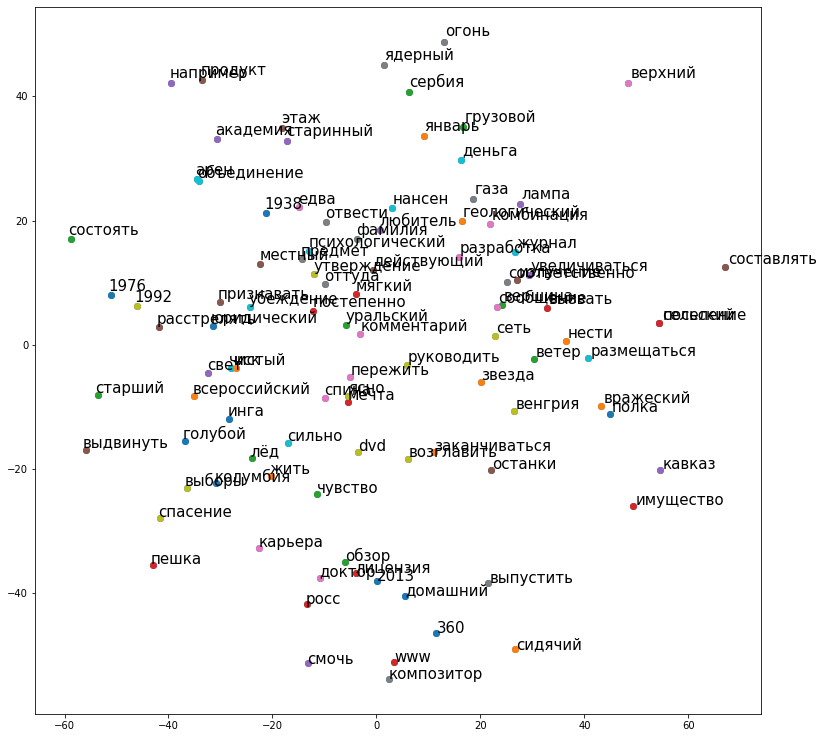

In [117]:
random_inds = np.random.choice(range(len(id2word)), 100, replace=False) 
# res = svd.components_.T[random_inds] # закомментируйте эту ячейку для TSNE
res = tsne[random_inds] # а эту наоборот раскомментируйте

plt.figure(figsize=(13,13))
plt.scatter(res[:,0], res[:,1])
for i, coor in enumerate(random_inds):
    x, y = res[i, 0], res[i, 1]
    plt.scatter(x, y)
    
    plt.annotate(id2word[coor], xy=(x, y), xytext=(x*1.01, y*1.01), textcoords='data',
                   ha='left', va='bottom', fontsize=15)

Получается не очень красиво. Почти все слова сбиваются в кучу. 

Но визуализация ещё ничего не говорит. Посмотрим на близкие слова.

Перестроим разложения с большим количеством параметров.

In [128]:
nmf = NMF(50)
nmf.fit(X)

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=50, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [129]:
svd = TruncatedSVD(50)
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=5,
       random_state=None, tol=0.0)

In [130]:
id2word = {i:w for i,w in enumerate(cv.get_feature_names())}
word2id = {w:i for i,w in id2word.items()}

In [131]:
id2vec_svd = nmf.components_.T

In [132]:
id2vec_nmf = svd.components_.T

In [133]:
def most_similar(word, id2vec):
    similar = [id2word[i] for i in cosine_distances(id2vec[word2id[word]].reshape(1, -1), id2vec).argsort()[0][:10]]
    return similar

In [141]:
most_similar('крайний', id2vec_svd)
# попробуйте другие слова

['крайний',
 'путешествие',
 'дикий',
 'индийский',
 'песок',
 'описание',
 'описывать',
 'найти',
 'оттуда',
 'след']

In [137]:
most_similar("вагон", id2vec_nmf)

['вагон',
 'метрополитен',
 'трамвайный',
 'трамвай',
 'эксплуатация',
 'депо',
 'тепловоз',
 'линия',
 'маршрут',
 'скоростной']

По похожим словам вектора выглядят достаточно хорошо.

Попробуем ещё кластеризовть полученные слова. Одна из метрик хороших векторов - их кластеризуемость (т.е. насколько хорошие получаются кластеры, можно ли сразу дать им какое-то название).

Сделаем кластеризацию с помощью MiniBatchKmeans.

In [142]:
cluster = MiniBatchKMeans(1000, n_init=2, verbose=1, max_no_improvement=100, reassignment_ratio=0.4)
cluster.fit(nmf.components_.T)

Init 1/2 with method: k-means++


/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=1000. Setting it to 3*k
  init_size=init_size)


Inertia for init 1/2: 8.339899
Init 2/2 with method: k-means++
Inertia for init 2/2: 14.061274
Minibatch iteration 1/5000: mean batch inertia: 1.691735, ewa inertia: 1.691735 
Minibatch iteration 2/5000: mean batch inertia: 0.483981, ewa inertia: 1.643435 
Minibatch iteration 3/5000: mean batch inertia: 0.222453, ewa inertia: 1.586607 
Minibatch iteration 4/5000: mean batch inertia: 0.591732, ewa inertia: 1.546820 
Minibatch iteration 5/5000: mean batch inertia: 0.865068, ewa inertia: 1.519555 
Minibatch iteration 6/5000: mean batch inertia: 0.393962, ewa inertia: 1.474541 
Minibatch iteration 7/5000: mean batch inertia: 0.387789, ewa inertia: 1.431079 
Minibatch iteration 8/5000: mean batch inertia: 0.412660, ewa inertia: 1.390351 
Minibatch iteration 9/5000: mean batch inertia: 1.343997, ewa inertia: 1.388497 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 10/5000: mean batch inertia: 0.383591, ewa inertia: 1.348309 
Minibatch iteration 11/5000: mean batch iner

Minibatch iteration 95/5000: mean batch inertia: 0.547813, ewa inertia: 0.765666 
Minibatch iteration 96/5000: mean batch inertia: 0.499455, ewa inertia: 0.755019 
Minibatch iteration 97/5000: mean batch inertia: 0.661003, ewa inertia: 0.751259 
Minibatch iteration 98/5000: mean batch inertia: 0.795075, ewa inertia: 0.753012 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 99/5000: mean batch inertia: 0.591647, ewa inertia: 0.746558 
Minibatch iteration 100/5000: mean batch inertia: 0.422650, ewa inertia: 0.733605 
Minibatch iteration 101/5000: mean batch inertia: 0.868772, ewa inertia: 0.739010 
Minibatch iteration 102/5000: mean batch inertia: 1.299168, ewa inertia: 0.761412 
Minibatch iteration 103/5000: mean batch inertia: 0.836691, ewa inertia: 0.764423 
Minibatch iteration 104/5000: mean batch inertia: 0.293924, ewa inertia: 0.745607 
Minibatch iteration 105/5000: mean batch inertia: 0.505567, ewa inertia: 0.736007 
Minibatch iteration 106/5000: mean batch i

Minibatch iteration 212/5000: mean batch inertia: 1.348149, ewa inertia: 0.724081 
Minibatch iteration 213/5000: mean batch inertia: 0.612483, ewa inertia: 0.719618 
Minibatch iteration 214/5000: mean batch inertia: 0.455676, ewa inertia: 0.709062 
Minibatch iteration 215/5000: mean batch inertia: 0.834600, ewa inertia: 0.714083 
Minibatch iteration 216/5000: mean batch inertia: 0.577560, ewa inertia: 0.708623 
Minibatch iteration 217/5000: mean batch inertia: 0.547868, ewa inertia: 0.702194 
Minibatch iteration 218/5000: mean batch inertia: 0.599584, ewa inertia: 0.698090 
Minibatch iteration 219/5000: mean batch inertia: 0.384021, ewa inertia: 0.685530 
Minibatch iteration 220/5000: mean batch inertia: 0.481724, ewa inertia: 0.677379 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 221/5000: mean batch inertia: 0.365580, ewa inertia: 0.664910 
Minibatch iteration 222/5000: mean batch inertia: 0.640170, ewa inertia: 0.663921 
Minibatch iteration 223/5000: mean ba

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=100,
        n_clusters=1000, n_init=2, random_state=None,
        reassignment_ratio=0.4, tol=0.0, verbose=1)

Сохраним кластеры в текстовый файл и просто полистаем.

In [143]:

cls = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cls[cl].append(id2word[i])
# откройте в любом текстовом редакторе
f = open('cluster_nmf.txt', 'w')
for cl in cls:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls[cl]))
    f.write('\n\n')
f.close()

## Word2Vec и Fasttext

Проделаем тоже самое для ворд2века и фастекста. 

Интерфейс в gensim практически такой же как и в LDA. Только строить словарь не нужно.

In [60]:
fast_text = gensim.models.FastText([text.split() for text in data_norm], size=50, 
                                   min_n=4, max_n=8) 
w2v = gensim.models.Word2Vec([text.split() for text in data_norm], size=50, sg=1)


/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


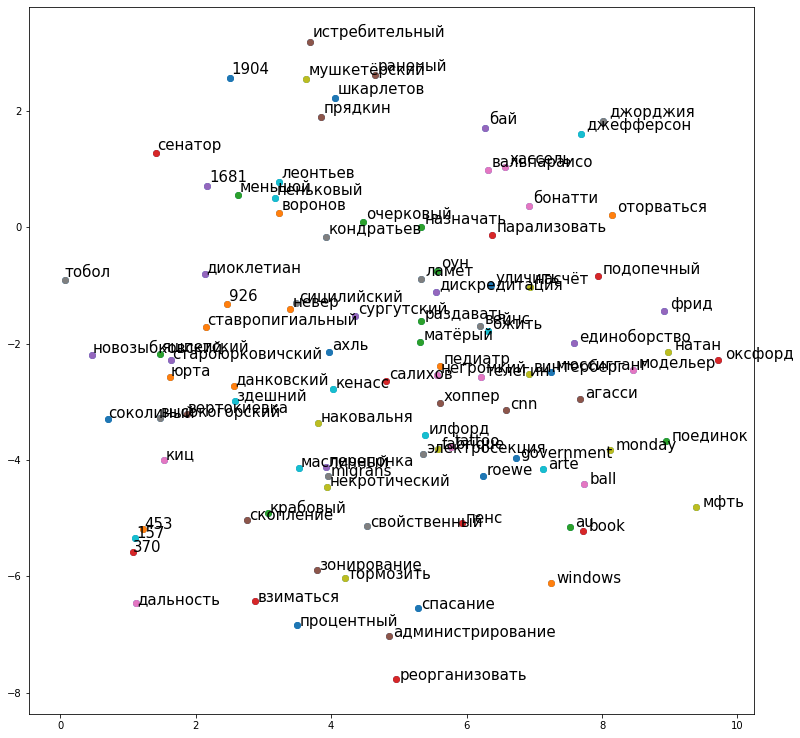

In [61]:
random_words = np.random.choice(w2v.wv.index2word, 100, replace=False)
res = w2v[random_words]
res = TSNE(2).fit_transform(res)

plt.figure(figsize=(13,13))
plt.scatter(res[:,0], res[:,1])
for i, coor in enumerate(res):
    x, y = coor
    plt.scatter(x, y)
    
    plt.annotate(random_words[i], xy=(x, y), xytext=(x*1.01, y*1.01), textcoords='data',
                   ha='left', va='bottom', fontsize=15)

Опять же ничего хорошего на график не рисуется.

Посмотрим на близкие слова.

In [160]:
fast_text.most_similar('большой')
# чтобы отчетливо увидеть различия фастекста и ворд2века
# подставьте какое-то несуществующее слово (например, с опечаткой или с говорящей частью - "хренология" хороший пример)
# или попробуйте ввести слово с характерной составляющей (суффиксом прошедшего времени, приставкой пере)

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('небольшой', 0.9298873543739319),
 ('Небольшой', 0.9287022352218628),
 ('живой', 0.8650323748588562),
 ('болотистой', 0.8629487752914429),
 ('меловой', 0.8475579023361206),
 ('неглубокой', 0.8466266393661499),
 ('красивой', 0.8459287285804749),
 ('больничной', 0.8440950512886047),
 ('ледниковой', 0.8436310887336731),
 ('немалой', 0.8399122953414917)]

In [161]:
w2v.most_similar('большой')

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('больший', 0.8886723518371582),
 ('значительный', 0.8560697436332703),
 ('огромный', 0.8278383016586304),
 ('небольшой', 0.7668909430503845),
 ('наибольший', 0.7583914995193481),
 ('многочисленный', 0.7253884673118591),
 ('незначительный', 0.7240444421768188),
 ('немалый', 0.7154432535171509),
 ('меньший', 0.7153381705284119),
 ('заметный', 0.7112590670585632)]

Ну и на кластеры давайте тоже посмотрим.

In [163]:
vocab = w2v.wv.index2word
matrix = np.zeros((len(vocab), 50))

for i, word in enumerate(vocab):
    if word in vocab:
        matrix[i] = w2v[word]

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [166]:
len(vocab)

46368

In [167]:
cluster = MiniBatchKMeans(10000, n_init=2, verbose=1, max_no_improvement=100, reassignment_ratio=0.4)
cluster.fit(matrix)
cls = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cls[cl].append(vocab[i])

f = open('cluster_ft.txt', 'w')
for cl in cls:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls[cl]))
    f.write('\n\n')
f.close()

Init 1/2 with method: k-means++


/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:1418: RuntimeWarning: init_size=300 should be larger than k=10000. Setting it to 3*k
  init_size=init_size)


Inertia for init 1/2: 7.132841
Init 2/2 with method: k-means++
Inertia for init 2/2: 3.774336
Minibatch iteration 1/46400: mean batch inertia: 0.617234, ewa inertia: 0.617234 
Minibatch iteration 2/46400: mean batch inertia: 0.626119, ewa inertia: 0.617272 
Minibatch iteration 3/46400: mean batch inertia: 0.681557, ewa inertia: 0.617550 
Minibatch iteration 4/46400: mean batch inertia: 0.686230, ewa inertia: 0.617846 
Minibatch iteration 5/46400: mean batch inertia: 0.683689, ewa inertia: 0.618130 
Minibatch iteration 6/46400: mean batch inertia: 0.518977, ewa inertia: 0.617702 
Minibatch iteration 7/46400: mean batch inertia: 0.656683, ewa inertia: 0.617870 
Minibatch iteration 8/46400: mean batch inertia: 0.728692, ewa inertia: 0.618348 
Minibatch iteration 9/46400: mean batch inertia: 0.747092, ewa inertia: 0.618904 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 10/46400: mean batch inertia: 0.728275, ewa inertia: 0.619375 
Minibatch iteration 11/46400: mean 

Minibatch iteration 95/46400: mean batch inertia: 0.622218, ewa inertia: 0.634817 
Minibatch iteration 96/46400: mean batch inertia: 0.728152, ewa inertia: 0.635219 
Minibatch iteration 97/46400: mean batch inertia: 0.636516, ewa inertia: 0.635225 
Minibatch iteration 98/46400: mean batch inertia: 0.594851, ewa inertia: 0.635051 
Minibatch iteration 99/46400: mean batch inertia: 0.565917, ewa inertia: 0.634753 
[MiniBatchKMeans] Reassigning 50 cluster centers.
Minibatch iteration 100/46400: mean batch inertia: 0.556212, ewa inertia: 0.634414 
Minibatch iteration 101/46400: mean batch inertia: 0.583040, ewa inertia: 0.634192 
Converged (lack of improvement in inertia) at iteration 101/46400
Computing label assignment and total inertia


Преимущество фастекста в том, что он учитывает символьные нграммы (что примерно равно учету морфологии). Попробуем подать ему на вход ненормализованные тексты.

In [169]:
corpus = [tokenize(text).split() for text in data]
corpus = list(filter(bool, corpus))
fast_text = gensim.models.FastText(corpus, size=50)

KeyboardInterrupt: 

In [ ]:
vocab = fast_text.wv.index2word
matrix = np.zeros((len(vocab), 50))

for i, word in enumerate(vocab):
    if word in vocab:
        matrix[i] = fast_text[word]
        
cluster = MiniBatchKMeans(5000, n_init=2, verbose=1, max_no_improvement=300, reassignment_ratio=0.4)
cluster.fit(matrix)
cls = defaultdict(list)

for i, cl in enumerate(cluster.labels_):
    cls[cl].append(vocab[i])

f = open('cluster_ft.txt', 'w')
for cl in cls:
    f.write('### '+ str(cl) + ' ###\n')
    f.write('\n'.join(cls[cl]))
    f.write('\n\n')
f.close()

### Векторные представления в настоящей задаче

Все вышеперечисленое относится к intrinsic (внутренним) метрикам. Есть также много других схожих (аналогии, корреляция с оценками людей и т.д). Но эти метрики не всегда показывают какой из методов сработает в реальной задаче. Поэтому при выборе методов и подборе параметров лучше ориентироваться на оценки качества решаемой задачи.

Проверим как все эти методы работают на задаче определения парафразов (предложений, которые выражают одно и то же, но не равны друг другу).

Данные взяты вот отсюда: http://paraphraser.ru/

Коллекция состоит из пар предложения (заголвков статей) и метки класса (-1,0,1). -1 не парафраз, 1 - парафраз, 0 - что-то непонятное.

In [170]:
corpus_xml = html.fromstring(open('paraphraser/paraphrases.xml', 'rb').read())
texts_1 = []
texts_2 = []
classes = []

for p in corpus_xml.xpath('//paraphrase'):
    texts_1.append(p.xpath('./value[@name="text_1"]/text()')[0])
    texts_2.append(p.xpath('./value[@name="text_2"]/text()')[0])
    classes.append(p.xpath('./value[@name="class"]/text()')[0])
    
data = pd.DataFrame({'text_1':texts_1, 'text_2':texts_2, 'label':classes})

In [171]:
data['text_1_norm'] = data['text_1'].apply(normalize)
data['text_2_norm'] = data['text_2'].apply(normalize)

In [178]:
data.head(10)

,text_1,text_2,label,text_1_norm,text_2_norm
0,Полицейским разрешат стрелять на поражение по ...,Полиции могут разрешить стрелять по хулиганам ...,0,полицейский разрешить стрелять поражение гражд...,полиция мочь разрешить стрелять хулиган травма...
1,Право полицейских на проникновение в жилище ре...,Правила внесудебного проникновения полицейских...,0,право полицейский проникновение жилища решить ...,правило внесудебный проникновение полицейский ...
2,Президент Египта ввел чрезвычайное положение в...,Власти Египта угрожают ввести в стране чрезвыч...,0,президент египет ввести чрезвычайный положение...,власть египет угрожать ввести страна чрезвычай...
3,Вернувшихся из Сирии россиян волнует вопрос тр...,Самолеты МЧС вывезут россиян из разрушенной Си...,-1,вернуться сирия россиянин волновать вопрос тру...,самолёт мчс вывезти россиянин разрушить сирия
4,В Москву из Сирии вернулись 2 самолета МЧС с р...,Самолеты МЧС вывезут россиян из разрушенной Си...,0,москва сирия вернуться 2 самолёт мчс россиянин...,самолёт мчс вывезти россиянин разрушить сирия
5,Приставы соберут отпечатки пальцев российских ...,Приставы снимут отпечатки пальцев у злостных н...,1,пристав собрать отпечаток палец российский дол...,пристав снять отпечаток палец злостный неплате...
6,На саратовского дебошира с борта самолета Моск...,Саратовский дебошир отказывается возвращаться ...,-1,саратовский дебошир борт самолёт москва хургад...,саратовский дебошир отказываться возвращаться ...
7,ЦИК хочет отказаться от электронной системы по...,ЦИК может отказаться от электронных средств по...,0,цик хотеть отказаться электронный система подс...,цик отказаться электронный средство подсчёт голос
8,Суд Петербурга оставил на потом дело о гибели ...,Лондонский Гайд-парк - это не место для митинг...,-1,суд петербург оставить дело гибель подросток п...,лондонский гайд-парк это место митинг прежде парк
9,Страны ОПЕК сократили добычу нефти на 1 млн ба...,Обама продлил полномочия НАСА по сотрудничеств...,-1,страна опека сократить добыча нефть 1 миллион ...,обама продлить полномочие наса сотрудничество ...


In [179]:
data.loc[5, ['text_1', 'text_2']].values

array(['Приставы соберут отпечатки пальцев российских должников.',
       'Приставы снимут отпечатки пальцев у злостных неплательщиков.'],
      dtype=object)

In [180]:
data.loc[8, ['text_1', 'text_2']].values

array(['Суд Петербурга оставил на потом дело о гибели подростка в полиции.',
       'Лондонский Гайд-парк - это не место для митингов, а прежде всего парк.'],
      dtype=object)

Тексты короткие и их маловато, поэтому возьмем модели, обученные на новостных текстах.

Для решения задачи преобразуем каждый текст и конкатенируем их векторы.

In [72]:
tfidf = TfidfVectorizer(min_df=3, max_df=0.4, max_features=1000)
tfidf.fit(pd.concat([data['text_1_norm'], data['text_2_norm']]))

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.4, max_features=1000, min_df=3,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

### SVD

In [73]:
svd = TruncatedSVD(200)

X_text_1 = svd.fit_transform(tfidf.transform(data['text_1_norm']))
X_text_2 = svd.fit_transform(tfidf.transform(data['text_2_norm']))

X_text = np.concatenate([X_text_1, X_text_2], axis=1)

In [74]:
X_text.shape

(7227, 400)

In [75]:
y = data['label'].values
print(y.shape)

(7227,)


Для простоты не будем использовать кросс-валидацию, а просто разобьем на трейн и тест. Зафиксируем сид, чтобы каждый раз получалось одинаковое разбиение.

In [76]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text, y, random_state=1)
clf = LogisticRegression(C=1000, class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.50      0.52      0.51       629
          0       0.47      0.44      0.46       737
          1       0.34      0.36      0.35       441

avg / total       0.45      0.45      0.45      1807



In [77]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text, y, random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=10,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.55      0.53      0.54       629
          0       0.49      0.55      0.51       737
          1       0.36      0.30      0.33       441

avg / total       0.48      0.48      0.48      1807



### NMF

Точно также (делаем пару векторов, конкатенируем, суём в логрег или рандом форест)

In [80]:
nmf = NMF(100)
X_text_1_nmf = nmf.fit_transform(tfidf.transform(data['text_1_norm']))
X_text_2_nmf = nmf.fit_transform(tfidf.transform(data['text_2_norm']))

X_text_nmf = np.concatenate([X_text_1_nmf, X_text_2_nmf], axis=1)

In [81]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_nmf, y,random_state=1)
clf = LogisticRegression(C=10000, class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.49      0.51      0.50       629
          0       0.48      0.50      0.49       737
          1       0.36      0.33      0.34       441

avg / total       0.46      0.46      0.46      1807



In [82]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_nmf, y,random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.46      0.61      0.53       629
          0       0.48      0.37      0.42       737
          1       0.36      0.33      0.35       441

avg / total       0.44      0.44      0.44      1807



### Word2Vec и Fastext

Преобразование текста в вектор с помощью w2v и fasttext не тривиальная задача. Самый простой и распространенный способ - усреднение отдельных векторов слов. Можно ещё использовать tfidf отдельных слов, для взвешивания отдельных векторов (чтобы частотные векторы не утягивали все на себя).

In [83]:
def get_embedding(text, model, dim):
    text = text.split()
    
    # чтобы не доставать одно слово несколько раз
    # сделаем счетчик, а потом векторы домножим на частоту
    words = Counter(text)
    total = len(text)
    vectors = np.zeros((len(words), dim))
    
    for i,word in enumerate(words):
        try:
            v = model[word]
            vectors[i] = v*(words[word]/total) # просто умножаем вектор на частоту
        except (KeyError, ValueError):
            continue
    
    if vectors.any():
        vector = np.average(vectors, axis=0)
    else:
        vector = np.zeros((dim))
    
    return vector
        

In [84]:
dim = 50
X_text_1_w2v = np.zeros((len(data['text_1_norm']), dim))
X_text_2_w2v = np.zeros((len(data['text_2_norm']), dim))

for i, text in enumerate(data['text_1_norm'].values):
    X_text_1_w2v[i] = get_embedding(text, w2v, dim)
    
for i, text in enumerate(data['text_2_norm'].values):
    X_text_2_w2v[i] = get_embedding(text, w2v, dim)

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [85]:
X_text_w2v = np.concatenate([X_text_1_w2v, X_text_2_w2v], axis=1)

In [86]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_w2v, y,random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.59      0.47      0.52       629
          0       0.48      0.54      0.51       737
          1       0.35      0.37      0.36       441

avg / total       0.48      0.47      0.48      1807



In [87]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_w2v, y,random_state=1)
clf = LogisticRegression(C=1000)
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.46      0.45      0.46       629
          0       0.45      0.67      0.54       737
          1       0.43      0.09      0.14       441

avg / total       0.45      0.45      0.41      1807



In [88]:
dim = 50
data['text_1_notnorm'] = data['text_1'].apply(tokenize)
data['text_2_notnorm'] = data['text_2'].apply(tokenize)

X_text_1_ft = np.zeros((len(data['text_1_notnorm']), dim))
X_text_2_ft = np.zeros((len(data['text_2_notnorm']), dim))

for i, text in enumerate(data['text_1_notnorm'].values):
    X_text_1_ft[i] = get_embedding(text, fast_text, dim)
    
for i, text in enumerate(data['text_2_notnorm'].values):
    X_text_2_ft[i] = get_embedding(text, fast_text, dim)

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


In [91]:
X_text_ft = np.concatenate([X_text_1_ft, X_text_2_ft], axis=1)

In [92]:
train_X, valid_X, train_y, valid_y = train_test_split(X_text_ft, y,random_state=1)
clf = RandomForestClassifier(n_estimators=100, max_depth=7, min_samples_leaf=15,
                             class_weight='balanced')
clf.fit(train_X, train_y)
preds = clf.predict(valid_X)
print(classification_report(valid_y, preds))


             precision    recall  f1-score   support

         -1       0.56      0.51      0.53       629
          0       0.48      0.55      0.51       737
          1       0.40      0.36      0.38       441

avg / total       0.49      0.49      0.49      1807



### Использование предобученных моделей

Определение перефразирования сделано на новостных текстах и предобученные открытые модели тут подойдут. Для русского готовые модели можно взять на сайте https://rusvectores.org/ru/models/ 

Нужно скачать какую-то модели, распаковать и открыть в генсиме.


In [181]:
# я скачал вот эту tayga_upos_skipgram_300_2_2019 
# и распаковал архив в папку taiga_w2v_model
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('180/model.bin', binary=True)

/Users/mnefedov/.pyenv/versions/3.6.5/lib/python3.6/site-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [182]:
model.most_similar('февраль_NOUN')

[('март_NOUN', 0.9567033052444458),
 ('ноябрь_NOUN', 0.9523458480834961),
 ('декабрь_NOUN', 0.9509049654006958),
 ('апрель_NOUN', 0.949961245059967),
 ('январь_NOUN', 0.9472224712371826),
 ('октябрь_NOUN', 0.937659740447998),
 ('май_NOUN', 0.911928117275238),
 ('июнь_NOUN', 0.9011650681495667),
 ('сентябрь_NOUN', 0.899361252784729),
 ('июль_NOUN', 0.8842827677726746)]

Слова в модели хранятся в нормализованном виде с прибавленной частью речи. Для пребобработки там использовался udpipe, вызывать его в тетрадке неудобно, поэтому можно заменить его на майстем (по большей части все будет совпадать). На сайте есть ссылка на файл с соответствием тэгов майстема тэгам Udpipe (https://github.com/akutuzov/universal-pos-tags/blob/4653e8a9154e93fe2f417c7fdb7a357b7d6ce333/ru-rnc.map)

In [183]:
mapping = {}

for line in open('ru-rnc.map.txt'):
    ms, ud = line.strip('\n').split()
    mapping[ms] = ud

In [184]:
mapping

{'A': 'ADJ',
 'ADV': 'ADV',
 'ADVPRO': 'ADV',
 'ANUM': 'ADJ',
 'APRO': 'DET',
 'COM': 'ADJ',
 'CONJ': 'SCONJ',
 'INTJ': 'INTJ',
 'NONLEX': 'X',
 'NUM': 'NUM',
 'PART': 'PART',
 'PR': 'ADP',
 'S': 'NOUN',
 'SPRO': 'PRON',
 'UNKN': 'X',
 'V': 'VERB'}

In [185]:
from pymystem3 import Mystem
m = Mystem()

In [186]:

def normalize_mystem(text):
    tokens = []
    norm_words = m.analyze(text)
    for norm_word in norm_words:
        if 'analysis' not in norm_word:
            continue
            
        if not len(norm_word['analysis']):
            lemma = norm_word['text']
            pos = 'UNKN'
        else:
            lemma = norm_word["analysis"][0]["lex"].lower().strip()
            pos = norm_word["analysis"][0]["gr"].split(',')[0]
            pos = pos.split('=')[0].strip()
        pos = mapping[pos]
        tokens.append(lemma+'_'+pos)

    return tokens


Эту функцию можно применять к любому тексты и получать на выходе токены, по которым можно обращаться к модели напрямую.

In [187]:
normalize_mystem('Обучить классификатор парафразов на предобученной модели вам нужно будет дома')

['обучать_VERB',
 'классификатор_NOUN',
 'парафраз_NOUN',
 'на_ADP',
 'предобученный_ADJ',
 'модель_NOUN',
 'вы_PRON',
 'нужно_ADV',
 'быть_VERB',
 'дома_ADV']

In [189]:
model['обучать_VERB'].shape

(300,)

Векторизовать тексты и обучать классификаторы вы уже умеете. Проверить лучше ли работает предобученная модель, чем та, что мы обучили сами, вы тоже сможете!